# Kalman Filter und Sensor Fusion

siehe auch:
- https://www.kalmanfilter.net/default.aspx

In [1]:
import numpy as np
import matplotlib.pylab as plt

## Realistisches Beispiel für einen Kalman Filter

Für eine Rakete soll ein Höhenmesser implementiert werden.

Wir generieren/simulieren Daten für einen solchen Flug. Die Daten werden erzeugt durch einfache Euler-Integration ausgehend von vorgegeben Beschleunigungsdaten. Zu diese "exakten" Daten wird dann Rauschen addiert um Messwerte zu erzeugen.

In [2]:
# rocket flight test data including noise

dt = 0.1
noise_s = 10
noise_a = 1

t = np.arange(0, 20, dt)

n = t.shape
k = n[0]//4

a = np.zeros(n)
v = np.zeros(n)
s = np.zeros(n)

a[:(1*k)]      =  0.    #  0...5s:  5s auf Rampe
a[(1*k):(2*k)] = 10.    #  5..10s:  5s Brenndauer; Beschleunigung 10m/s^2
a[(2*k):]      = -9.81  # 10..20s: 10s Ballistische Bahn; Beschleunigung -g

dv = a[1:] * dt
v[1:] = np.cumsum(dv)

ds = v[1:] * dt
s[1:] = np.cumsum(ds)

rg = np.random.Generator(np.random.PCG64(1234))  # produce always the same random sequence for comparisons of results

sn = noise_s * (rg.random(s.shape)*2-1)
an = noise_a * (rg.random(a.shape)*2-1)

s_meas = s + sn
a_meas = a + an

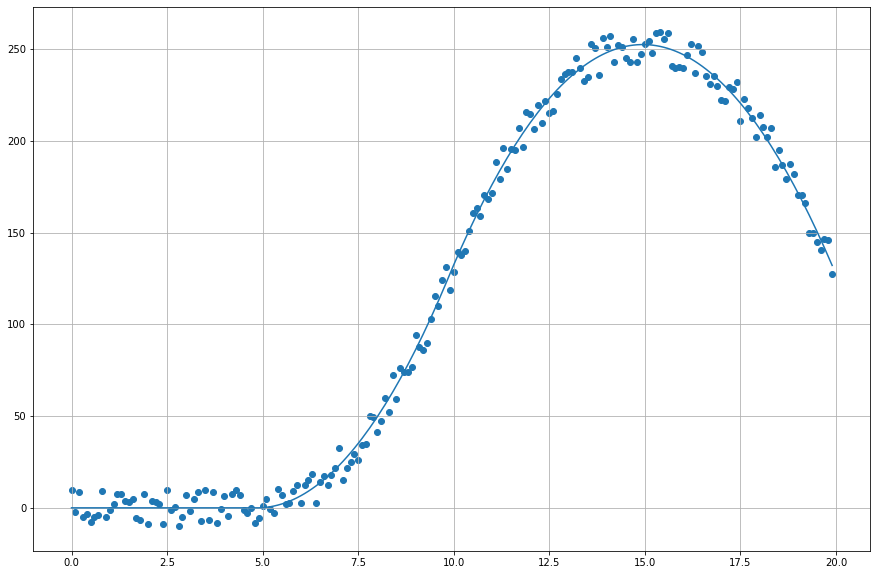

In [3]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.figure(dpi=150)

plt.scatter(t, s_meas)
plt.plot(t, s)

plt.grid()

plt.show()

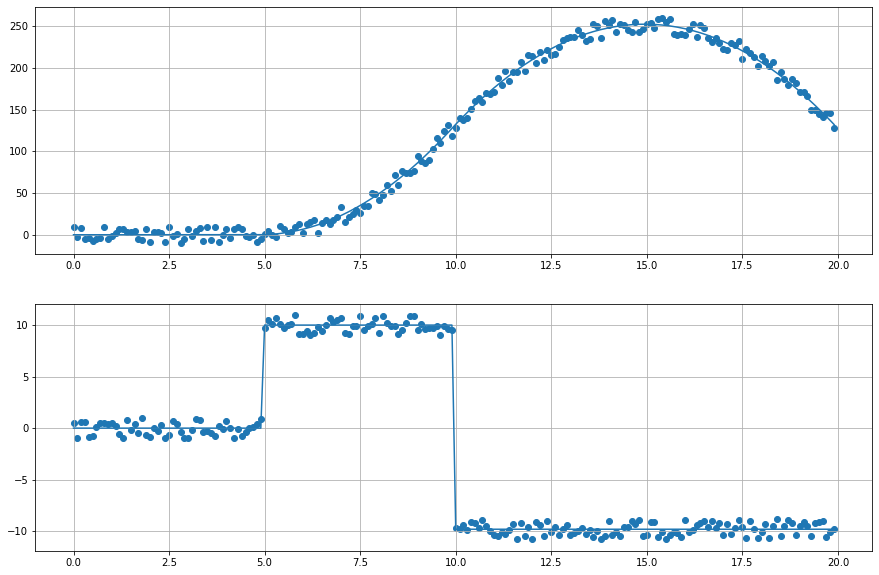

In [4]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.figure(dpi=150)

plt.subplot(211)

plt.scatter(t, s_meas)
plt.plot(t, s)

plt.grid()


plt.subplot(212)

plt.scatter(t, a_meas)
plt.plot(t, a)
#plt.scatter(t, v)
#plt.plot(t, v)

plt.grid()

plt.show()

## Kalman Filter mit 1 Sensor (Barometer)

Um die Parameter und Begriffe im Zusammenhang mit Kalman Filtern zu verstehen werden wir hier in einem realistischen Beispiel zeigen, welche Werte diese Grössen annehmen. 

Dafür verwenden wir das Paket `pykalman` welches "dead-simple" Kalman Filter implementiert die sich dadurch auszeichnen, dass sie nicht bekannte Parameter schätzen bzw. aus vorhandenen Daten lernen können. Danach können wir das Resultat sowie die Parameter studieren. Der Filter ist durch diese Parameter vollständig bestimmt.

siehe auch:
- https://pykalman.github.io/
- https://en.wikipedia.org/wiki/Kalman_filter

In [5]:
from pykalman import KalmanFilter  # pip install pykalman

Als "observables" also von Sensoren gemessene Werte verwenden wir hier nur den Ort (Höhe). Als "states" also interne Variablen die den Zustand des Systems beschreiben verwenden wir den Ort (s), die Geschwindigkeit (v) und die Beschleunigung (a). Wir erhalten diese Grössen hier somit gratis mit dazu und können uns eine Integration (Euler, Runge-Kutta, etc.) ersparen.

Die Matrix $A$ ist die sogenannte "transition matrix" die beschreibt wie aus den letzten states (s, v, a) die neuen berechnet (integriert) werden, das ist das (physikalische) Modell. Berechnet werden die Einträge von A wie folgt:

$
s = s_0 + v_0 \cdot t + 1/2 \cdot a \cdot t^2 \\
v = v_0 + a \cdot t \\
a = a \\
$

$
A =
\left[ {\begin{array}{ccc}
  \frac{\partial s}{\partial s_0} & \frac{\partial s}{\partial v_0} & \frac{\partial s}{\partial a} \\
  \frac{\partial v}{\partial s_0} & \frac{\partial v}{\partial v_0} & \frac{\partial v}{\partial a} \\
  \frac{\partial a}{\partial s_0} & \frac{\partial a}{\partial v_0} & \frac{\partial a}{\partial a} \\
\end{array} } \right]
$

Wir trauen dem Modell sehr stark - tendenziell mehr als den Messdaten - darum setzen wir für die "transition_covariance" sehr tiefe Werte: $I_{3x3} \cdot 0.01$
Die "transition_covariance" wird vom Erwartungs-Maximierungs-Algorithmus (EM) lokal optimiert, darum muss ein nahe liegender Anfangswert vorgegeben werden.

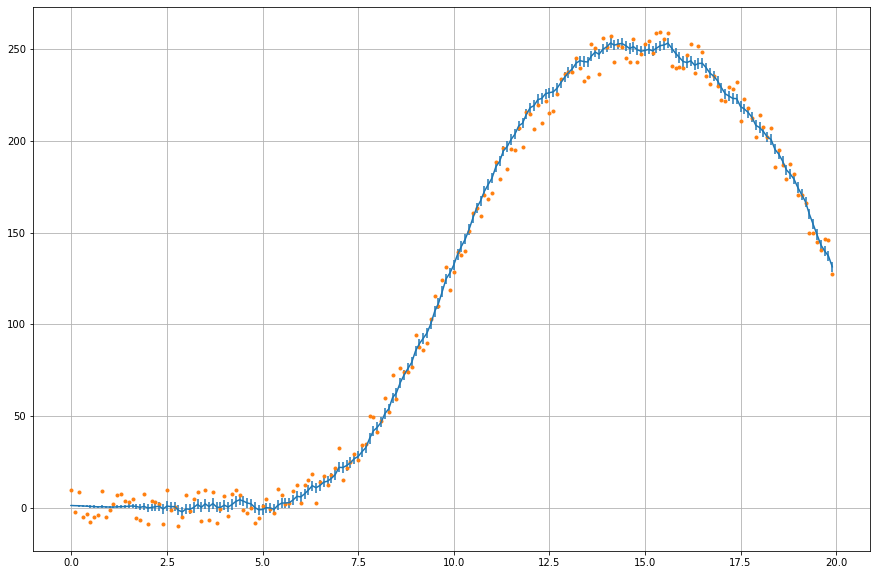

In [6]:
A = np.array([[1, dt, 0.5 * (dt**2)],
              [0,  1,            dt],
              [0,  0,             1]])

kf = KalmanFilter(transition_matrices = A, transition_covariance=0.01*np.eye(3), n_dim_state=3, n_dim_obs=1)
measurements = np.asarray([s_meas]).T  # 1 observation(s)
kf = kf.em(measurements)
#kf = kf.em(measurements[0:10])
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
#(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

test1 = filtered_state_means[:,0]

plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.plot(t, filtered_state_means[:,0])
plt.errorbar(t, filtered_state_means[:,0], yerr=np.sqrt(filtered_state_covariances[:,0,0]))
#plt.fill_between(t, (filtered_state_means[:,0] - np.sqrt(filtered_state_covariances[:,0,0])), (filtered_state_means[:,0] + np.sqrt(filtered_state_covariances[:,0,0])), alpha=0.5, label='error band')
plt.plot(t, s_meas, ".")
plt.grid()
plt.show()

Bemerkenswert ist, dass der Filter obschon er von Normal-/Gauss-Verteilten Fehlern ausgeht, hier auch mit Beispieldaten funktioniert deren Fehler gleichmässig (uniform) verteilt sind.

Erkennbar ist, dass der Filter klar weniger Abweichungen zeigt als die Messpunkte, d.h. wir haben eine Verbesserung erreicht. Gleichzeitig erhalten wir gratis die Geschwindigkeit und Beschleunigung dazu:

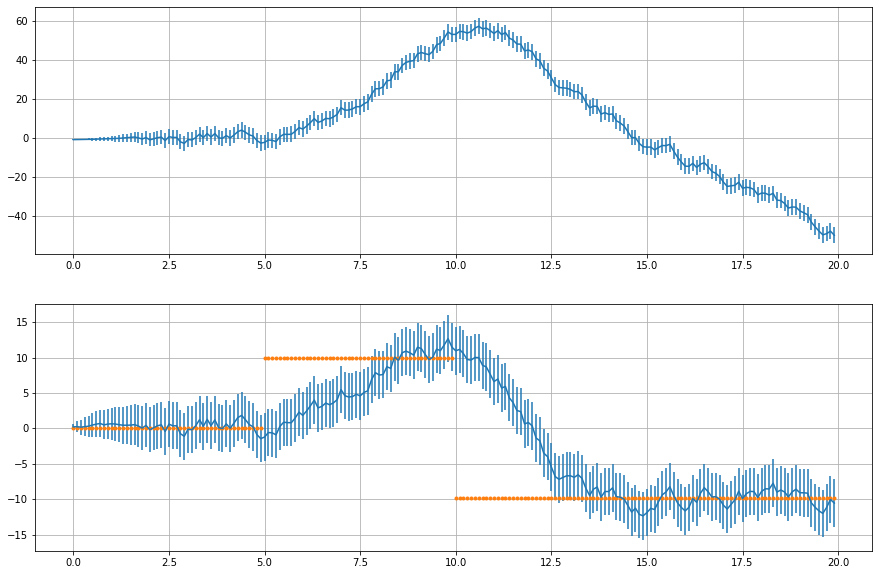

In [7]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.figure(dpi=150)

plt.subplot(211)

plt.errorbar(t, filtered_state_means[:,1], yerr=np.sqrt(filtered_state_covariances[:,1,1]))

plt.grid()


plt.subplot(212)

plt.errorbar(t, filtered_state_means[:,2], yerr=np.sqrt(filtered_state_covariances[:,2,2]))
plt.plot(t, a, ".")

plt.grid()

plt.show()

Die Parameter die verwendet wurden sind unten zu sehen, diese können als Basis verwendet werden einen selbst geschriebenen, optimierten und vereinfachten Kalman Filter zu implementieren.

In [8]:
print( "initial_state_mean:\n", kf.initial_state_mean )
print( "initial_state_covariance:\n", kf.initial_state_covariance )
print()
print( "transition_matrices:\n", kf.transition_matrices )
print( "transition_offsets:\n", kf.transition_offsets )
print( "transition_covariance:\n", kf.transition_covariance )
print()
print( "observation_matrices:\n", kf.observation_matrices )
print( "observation_offsets:\n", kf.observation_offsets )
print( "observation_covariance:\n", kf.observation_covariance )

initial_state_mean:
 [ 1.25054378 -0.78440239  0.22373549]
initial_state_covariance:
 [[ 0.12634126 -0.10281138  0.03493221]
 [-0.10281138  0.20185905 -0.10812951]
 [ 0.03493221 -0.10812951  0.11275177]]

transition_matrices:
 [[1.    0.1   0.005]
 [0.    1.    0.1  ]
 [0.    0.    1.   ]]
transition_offsets:
 [0. 0. 0.]
transition_covariance:
 [[ 6.83199099e-02 -8.15733524e-04 -1.61739920e-01]
 [-8.15764753e-04  2.58417894e-02  1.43985749e-04]
 [-1.61739965e-01  1.43799082e-04  5.23913422e-01]]

observation_matrices:
 [[1. 0. 0.]]
observation_offsets:
 [0.]
observation_covariance:
 [[38.36193392]]


## Kalman Filter mit 2 Sensoren (Barometer, IMU) inklusive Sensor Fusion

Um das Beispiel oben zu verbessern verwenden wir nun zusätzlich zum Ort (Höhe) nun auch Messungen der Beschleunigung. Damit machen wir "Sensor Fusion", denn die Messwerte kommen von verschiedenen Sensoren (Höhe von einem Barometer und Beschleunigung von einer IMU).

...